# MODELO 1 - CGAN para generar un dígito del mnist a pedido del usuario

In [1]:
import tensorflow as tf
print(tf.__version__)

2.13.0


- Importo las librerias neceasarias

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Activation, Embedding, Concatenate
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [4]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

0


- Cargo el dataset

In [4]:
tags = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']

(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = np.reshape(X_train, [-1, img_size, img_size, 1])
X_train = np.repeat(X_train, 3, axis=-1)  # Convertir a 3 canales
X_train = (X_train - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]
y_train = np.expand_dims(y_train, axis=-1) #expando la dimension de y_train

X_test = np.reshape(X_test, [-1, img_size, img_size, 1])
X_test = np.repeat(X_test, 3, axis=-1)  # Convertir a 3 canales
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]
y_test = np.expand_dims(y_test, axis=-1) #expando la dimension de y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 3)
(60000, 1)
(10000, 28, 28, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

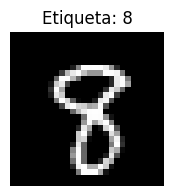

In [5]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"Etiqueta: {tags[y_train[idx][0]]}")
plt.show()

# Construcción del generador

In [14]:
def build_generator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label) # Capa de embedding para las etiquetas
    img_size_in = img_size // 4
    n_nodes = img_size_in * img_size_in
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa para las etiquetas
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa
 
    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido 
    n_nodes = 128 * img_size_in * img_size_in
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa para el ruido
    gen = LeakyReLU(negative_slope=0.2, name='Generator_LeakyReLU_1')(gen)
    gen = Reshape((img_size_in, img_size_in, 128), name='Generator_Reshape')(gen)
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li])
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 14x14x128
    gen = LeakyReLU(negative_slope=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 28x28x128
    gen = LeakyReLU(negative_slope=0.2, name='Generator_LeakyReLU_3')(gen)
    #---------------------------------------------------------------------------------#
    out_layer = Conv2D(3, (8, 8), activation='tanh', padding='same', name='Output_Conv2D')(gen)  # 28x28x3 
    #---------------------------------------------------------------------------------#
    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='generator_structure_m1.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [15]:
def build_discriminator(n_class, noise_dim, img_size):
    
    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    n_nodes = img_size * img_size 
    li = Dense(n_nodes, name='Label_Dense')(li) 
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li) 
  
    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input') 
    merge = Concatenate(name='Concatenate')([in_image, li]) 
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same', name='Conv2D_1')(merge) 
    fe = LeakyReLU(negative_slope=0.2, name='LeakyReLU_1')(fe) # 14x14x128
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same', name='Conv2D_2')(fe) 
    fe = LeakyReLU(negative_slope=0.2, name='LeakyReLU_2')(fe) # 7x7x128
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe)
    fe = Dropout(0.4, name='Dropout')(fe)
    #---------------------------------------------------------------------------------#
    out_layer = Dense(1, activation='sigmoid', name='Output')(fe)
    #---------------------------------------------------------------------------------#
    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='discriminator_structure_m1.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [16]:
def show_samples(num_samples, noise_dim, g_model, epoch):

  fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("evolution_m1", exist_ok=True)
  plt.savefig(f"evolution/digits_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [17]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [18]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [19]:
epoch_count = 50 # Cantidad de epocas
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 # Learning rate
n_class = len(tags)  # numero de clases

- Construyo el generador

In [20]:
g_optimizer = RMSprop(learning_rate=lr)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Latent_Input (InputLayer)   [(None, 100)]                0         []                            
                                                                                                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Generator_Dense (Dense)     (None, 6272)                 633472    ['Latent_Input[0][0]']        
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                          

- Construyo el discriminador

In [21]:
d_optimizer = RMSprop(learning_rate=lr)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                                  
 Label_Dense (Dense)         (None, 1, 784)               39984     ['Embedding[0][0]']           
                                                                                                  
 Image_Input (InputLayer)    [(None, 28, 28, 3)]          0         []                            
                                                                                      

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [14]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch 

        # Entreno el discriminador
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas

        with tf.GradientTape() as tape:
            pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
            pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales
            
            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        
        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas
        
        # Extender las listas con las etiquetas correspondientes
        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas
                
        
        grads = tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes
        d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador
    
        # Entreno el generador
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio        

        with tf.GradientTape() as tape: 
            fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
            predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
            g_loss = generator_loss(predictions) # Calculo la loss del generador
        
        grads = tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [15]:
@tf.function # Compiles the test_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):
        
        real_images, real_labels = image_batch 

        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales
            
        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        
        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas
        
        # Extender las listas con las etiquetas correspondientes
        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio        
        fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
        predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        g_loss = generator_loss(predictions) # Calculo la loss del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [16]:
def train(train_dataset, test_dataset, epoch_count, batch_size):

    d_loss_list_epoch_train = []
    g_loss_list_epoch_train = []
    d_loss_list_epoch_test = []
    g_loss_list_epoch_test = []
    precision_list_epoch_train = []
    recall_list_epoch_train = []
    f1_list_epoch_train = []
    accuracy_list_epoch_train = []
    precision_list_epoch_test = []
    recall_list_epoch_test = []
    f1_list_epoch_test = []
    accuracy_list_epoch_test = []
    d_loss_list_itern_train = []
    g_loss_list_itern_train = []
    d_loss_list_itern_test = []
    g_loss_list_itern_test = []

    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)
        d_loss_list_batch_train_aux = []
        g_loss_list_batch_train_aux = []
        d_loss_list_batch_test_aux = []
        g_loss_list_batch_test_aux = []
        precision_list_batch_train = []
        recall_list_batch_train = []
        f1_list_batch_train = []
        accuracy_list_batch_train = []
        precision_list_batch_test = []
        recall_list_batch_test = []
        f1_list_batch_test = []
        accuracy_list_batch_test = []

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches para el conjunto de entrenamiento

            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train_aux.append(d_loss_train) # Guardo la loss del discriminador
            g_loss_list_batch_train_aux.append(g_loss_train) # Guardo la loss del generador
            d_loss_list_itern_train.append(d_loss_train) # Guardo la loss del discriminador
            g_loss_list_itern_train.append(g_loss_train) # Guardo la loss del generador

            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,))

            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train.append(precision_train)
            recall_list_batch_train.append(recall_train)
            f1_list_batch_train.append(f1_train)
            accuracy_list_batch_train.append(accuracy_train)

            itern=itern+1

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches para el conjunto de testeo

            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_test_aux.append(d_loss_test) # Guardo la loss del discriminador
            g_loss_list_batch_test_aux.append(g_loss_test) # Guardo la loss del generador
            d_loss_list_itern_test.append(d_loss_test) # Guardo la loss del discriminador
            g_loss_list_itern_test.append(g_loss_test) # Guardo la loss del generador

            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test.append(precision_test)
            recall_list_batch_test.append(recall_test)
            f1_list_batch_test.append(f1_test)
            accuracy_list_batch_test.append(accuracy_test)

            itern=itern+1

        d_loss_list_epoch_train.append(np.mean(d_loss_list_batch_train_aux))
        g_loss_list_epoch_train.append(np.mean(g_loss_list_batch_train_aux))
        d_loss_list_epoch_test.append(np.mean(d_loss_list_batch_test_aux))
        g_loss_list_epoch_test.append(np.mean(g_loss_list_batch_test_aux))
        precision_list_epoch_train.append(np.mean(precision_list_batch_train))
        recall_list_epoch_train.append(np.mean(recall_list_batch_train))
        f1_list_epoch_train.append(np.mean(f1_list_batch_train))
        accuracy_list_epoch_train.append(np.mean(accuracy_list_batch_train))
        precision_list_epoch_test.append(np.mean(precision_list_batch_test))
        recall_list_epoch_test.append(np.mean(recall_list_batch_test))
        f1_list_epoch_test.append(np.mean(f1_list_batch_test))
        accuracy_list_epoch_test.append(np.mean(accuracy_list_batch_test))

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_train_aux)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_test_aux)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 5 == 0:
            show_samples(4, noise_dim, g_model, epoch)

    return d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_itern_train, g_loss_itern_train, d_loss_itern_test, g_loss_itern_test, d_loss_train, g_loss_train, d_loss_test, g_loss_test, precision_train, recall_train, f1_train, accuracy_train, precision_test, recall_test, f1_test, accuracy_test  = train(train_dataset, test_dataset, epoch_count, batch_size)
epochs = np.arange(1, epoch_count+1)

np.savez("/content/drive/MyDrive/Lembo/metricas_mnist_m1.npz", epochs= epochs, d_loss_itern_train=d_loss_itern_train, g_loss_itern_train=g_loss_itern_train, d_loss_itern_test=d_loss_itern_test, g_loss_itern_test=g_loss_itern_test, d_loss_train=d_loss_train, g_loss_train=g_loss_train, d_loss_test=d_loss_test, g_loss_test=g_loss_test, precision_train=precision_train, recall_train=recall_train, f1_train=f1_train, accuracy_train=accuracy_train, precision_test=precision_test, recall_test=recall_test, f1_test=f1_test, accuracy_test=accuracy_test)
g_model.save("gmodel_mnist_m1.keras")
d_model.save("dmodel_mnist_m1.keras")

Epoch:  1


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 91.34it/s] 


Train - Época: 1 -- Generator Loss: 1.08663809299469, Discriminator Loss: 1.0996737480163574
Test - Época: 1 -- Generator Loss: 0.813742458820343, Discriminator Loss: 1.0956169366836548

Tomó 66.28112530708313 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  2


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.61it/s]


Train - Época: 2 -- Generator Loss: 1.2165018320083618, Discriminator Loss: 1.04367196559906
Test - Época: 2 -- Generator Loss: 1.856133222579956, Discriminator Loss: 1.1669940948486328

Tomó 58.847395181655884 segundos. 


Epoch:  3


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.29it/s]


Train - Época: 3 -- Generator Loss: 1.3943935632705688, Discriminator Loss: 0.9628244638442993
Test - Época: 3 -- Generator Loss: 1.298311471939087, Discriminator Loss: 0.9693053960800171

Tomó 57.63942551612854 segundos. 


Epoch:  4


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 103.35it/s]


Train - Época: 4 -- Generator Loss: 1.6845078468322754, Discriminator Loss: 0.8211090564727783
Test - Época: 4 -- Generator Loss: 1.1709145307540894, Discriminator Loss: 0.7539153099060059

Tomó 57.2927041053772 segundos. 


Epoch:  5


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.38it/s]


Train - Época: 5 -- Generator Loss: 2.033487558364868, Discriminator Loss: 0.7101165652275085
Test - Época: 5 -- Generator Loss: 3.2114124298095703, Discriminator Loss: 0.875230073928833

Tomó 57.714953899383545 segundos. 


Epoch:  6


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 103.25it/s]


Train - Época: 6 -- Generator Loss: 2.188145399093628, Discriminator Loss: 0.6897684931755066
Test - Época: 6 -- Generator Loss: 0.7976099252700806, Discriminator Loss: 0.9830437302589417

Tomó 57.55711126327515 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  7


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.90it/s]


Train - Época: 7 -- Generator Loss: 2.2754194736480713, Discriminator Loss: 0.6923812627792358
Test - Época: 7 -- Generator Loss: 1.8452519178390503, Discriminator Loss: 0.5112578272819519

Tomó 57.833255767822266 segundos. 


Epoch:  8


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.42it/s]


Train - Época: 8 -- Generator Loss: 2.3817532062530518, Discriminator Loss: 0.679519772529602
Test - Época: 8 -- Generator Loss: 2.9840288162231445, Discriminator Loss: 0.6058692932128906

Tomó 57.673173666000366 segundos. 


Epoch:  9


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 99.56it/s]


Train - Época: 9 -- Generator Loss: 2.4701616764068604, Discriminator Loss: 0.6659085154533386
Test - Época: 9 -- Generator Loss: 2.886575698852539, Discriminator Loss: 0.46717020869255066

Tomó 58.8006432056427 segundos. 


Epoch:  10


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.79it/s]


Train - Época: 10 -- Generator Loss: 2.564976215362549, Discriminator Loss: 0.6589159369468689
Test - Época: 10 -- Generator Loss: 2.649571418762207, Discriminator Loss: 0.6002328395843506

Tomó 58.91134285926819 segundos. 


Epoch:  11


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.49it/s]


Train - Época: 11 -- Generator Loss: 2.6458020210266113, Discriminator Loss: 0.6499388217926025
Test - Época: 11 -- Generator Loss: 1.9245975017547607, Discriminator Loss: 0.5314344763755798

Tomó 58.33106255531311 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  12


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.58it/s]


Train - Época: 12 -- Generator Loss: 2.7098541259765625, Discriminator Loss: 0.6448892951011658
Test - Época: 12 -- Generator Loss: 3.499432325363159, Discriminator Loss: 0.5517939329147339

Tomó 58.33104586601257 segundos. 


Epoch:  13


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.46it/s]


Train - Época: 13 -- Generator Loss: 2.75964093208313, Discriminator Loss: 0.6381070017814636
Test - Época: 13 -- Generator Loss: 3.1232991218566895, Discriminator Loss: 0.3842231333255768

Tomó 57.738303422927856 segundos. 


Epoch:  14


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.95it/s]


Train - Época: 14 -- Generator Loss: 2.8191964626312256, Discriminator Loss: 0.6300570368766785
Test - Época: 14 -- Generator Loss: 2.737408399581909, Discriminator Loss: 0.4236212968826294

Tomó 59.35120630264282 segundos. 


Epoch:  15


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.08it/s]


Train - Época: 15 -- Generator Loss: 2.892169237136841, Discriminator Loss: 0.6148552298545837
Test - Época: 15 -- Generator Loss: 1.509361743927002, Discriminator Loss: 0.9678740501403809

Tomó 58.59280014038086 segundos. 


Epoch:  16


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.59it/s]


Train - Época: 16 -- Generator Loss: 2.9153568744659424, Discriminator Loss: 0.6144351959228516
Test - Época: 16 -- Generator Loss: 2.766212224960327, Discriminator Loss: 0.4490600526332855

Tomó 58.11775279045105 segundos. 


1/1 [==============================] - 0s 22ms/step
Epoch:  17


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.54it/s]


Train - Época: 17 -- Generator Loss: 2.976534843444824, Discriminator Loss: 0.6040138006210327
Test - Época: 17 -- Generator Loss: 2.5650711059570312, Discriminator Loss: 0.4680585563182831

Tomó 57.83981156349182 segundos. 


Epoch:  18


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.35it/s]


Train - Época: 18 -- Generator Loss: 2.993575096130371, Discriminator Loss: 0.6070666909217834
Test - Época: 18 -- Generator Loss: 2.570786237716675, Discriminator Loss: 0.6079167723655701

Tomó 57.44793677330017 segundos. 


Epoch:  19


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.09it/s]


Train - Época: 19 -- Generator Loss: 3.009183883666992, Discriminator Loss: 0.6063361763954163
Test - Época: 19 -- Generator Loss: 2.98850679397583, Discriminator Loss: 0.3894957900047302

Tomó 57.37886619567871 segundos. 


Epoch:  20


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.63it/s]


Train - Época: 20 -- Generator Loss: 3.0198299884796143, Discriminator Loss: 0.6056205630302429
Test - Época: 20 -- Generator Loss: 3.9034512042999268, Discriminator Loss: 0.4339420795440674

Tomó 58.181748390197754 segundos. 


Epoch:  21


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 103.40it/s]


Train - Época: 21 -- Generator Loss: 2.9858057498931885, Discriminator Loss: 0.620408833026886
Test - Época: 21 -- Generator Loss: 1.9415886402130127, Discriminator Loss: 0.5706398487091064

Tomó 57.71651649475098 segundos. 


1/1 [==============================] - 0s 25ms/step
Epoch:  22


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.63it/s]


Train - Época: 22 -- Generator Loss: 2.9974327087402344, Discriminator Loss: 0.6160084009170532
Test - Época: 22 -- Generator Loss: 2.0604403018951416, Discriminator Loss: 0.5234730243682861

Tomó 57.72135806083679 segundos. 


Epoch:  23


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 103.19it/s]


Train - Época: 23 -- Generator Loss: 2.9801015853881836, Discriminator Loss: 0.6262494921684265
Test - Época: 23 -- Generator Loss: 4.106040954589844, Discriminator Loss: 1.556087851524353

Tomó 58.5074303150177 segundos. 


Epoch:  24


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.33it/s]


Train - Época: 24 -- Generator Loss: 2.9567315578460693, Discriminator Loss: 0.6317334771156311
Test - Época: 24 -- Generator Loss: 3.939408540725708, Discriminator Loss: 0.9249266386032104

Tomó 58.353158950805664 segundos. 


Epoch:  25


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.74it/s]


Train - Época: 25 -- Generator Loss: 2.94996976852417, Discriminator Loss: 0.633566677570343
Test - Época: 25 -- Generator Loss: 2.610036611557007, Discriminator Loss: 0.5298007130622864

Tomó 58.61886692047119 segundos. 


Epoch:  26


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.11it/s]


Train - Época: 26 -- Generator Loss: 2.9305291175842285, Discriminator Loss: 0.6438884735107422
Test - Época: 26 -- Generator Loss: 2.921651601791382, Discriminator Loss: 0.4516053795814514

Tomó 57.783955335617065 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  27


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.27it/s]


Train - Época: 27 -- Generator Loss: 2.908146858215332, Discriminator Loss: 0.6441610455513
Test - Época: 27 -- Generator Loss: 1.4776769876480103, Discriminator Loss: 0.787463903427124

Tomó 57.85551428794861 segundos. 


Epoch:  28


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 98.85it/s]


Train - Época: 28 -- Generator Loss: 2.887268304824829, Discriminator Loss: 0.65504390001297
Test - Época: 28 -- Generator Loss: 2.3400309085845947, Discriminator Loss: 0.4427376985549927

Tomó 59.702866554260254 segundos. 


Epoch:  29


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.69it/s]


Train - Época: 29 -- Generator Loss: 2.8501505851745605, Discriminator Loss: 0.6487945318222046
Test - Época: 29 -- Generator Loss: 1.5453184843063354, Discriminator Loss: 0.6791498064994812

Tomó 58.59607791900635 segundos. 


Epoch:  30


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.33it/s]


Train - Época: 30 -- Generator Loss: 2.863908290863037, Discriminator Loss: 0.6525484323501587
Test - Época: 30 -- Generator Loss: 1.8149946928024292, Discriminator Loss: 0.877349317073822

Tomó 58.169942140579224 segundos. 


Epoch:  31


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.10it/s]


Train - Época: 31 -- Generator Loss: 2.8396599292755127, Discriminator Loss: 0.6676480174064636
Test - Época: 31 -- Generator Loss: 2.4601011276245117, Discriminator Loss: 0.47752657532691956

Tomó 58.34114456176758 segundos. 


1/1 [==============================] - 0s 23ms/step
Epoch:  32


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.47it/s]


Train - Época: 32 -- Generator Loss: 2.8408946990966797, Discriminator Loss: 0.6652508974075317
Test - Época: 32 -- Generator Loss: 2.431497573852539, Discriminator Loss: 0.6137942671775818

Tomó 58.20854210853577 segundos. 


Epoch:  33


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 103.48it/s]


Train - Época: 33 -- Generator Loss: 2.8203039169311523, Discriminator Loss: 0.6703436374664307
Test - Época: 33 -- Generator Loss: 2.092430830001831, Discriminator Loss: 0.5558300614356995

Tomó 57.34548091888428 segundos. 


Epoch:  34


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.40it/s]


Train - Época: 34 -- Generator Loss: 2.794264078140259, Discriminator Loss: 0.6799072027206421
Test - Época: 34 -- Generator Loss: 1.088945746421814, Discriminator Loss: 0.960304856300354

Tomó 57.558858156204224 segundos. 


Epoch:  35


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.35it/s]


Train - Época: 35 -- Generator Loss: 2.7867956161499023, Discriminator Loss: 0.6769213676452637
Test - Época: 35 -- Generator Loss: 2.7922444343566895, Discriminator Loss: 0.5644636154174805

Tomó 58.95429086685181 segundos. 


Epoch:  36


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 103.26it/s]


Train - Época: 36 -- Generator Loss: 2.769826650619507, Discriminator Loss: 0.6812469363212585
Test - Época: 36 -- Generator Loss: 3.145019054412842, Discriminator Loss: 0.6541933417320251

Tomó 57.555317640304565 segundos. 


1/1 [==============================] - 0s 25ms/step
Epoch:  37


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.71it/s]


Train - Época: 37 -- Generator Loss: 2.758869171142578, Discriminator Loss: 0.686738133430481
Test - Época: 37 -- Generator Loss: 2.304088830947876, Discriminator Loss: 0.5534161329269409

Tomó 57.88507676124573 segundos. 


Epoch:  38


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.97it/s]


Train - Época: 38 -- Generator Loss: 2.7426815032958984, Discriminator Loss: 0.6907204389572144
Test - Época: 38 -- Generator Loss: 3.5292067527770996, Discriminator Loss: 0.6613500118255615

Tomó 58.345314741134644 segundos. 


Epoch:  39


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.28it/s]


Train - Época: 39 -- Generator Loss: 2.7386295795440674, Discriminator Loss: 0.6954942345619202
Test - Época: 39 -- Generator Loss: 3.336289167404175, Discriminator Loss: 0.5349841117858887

Tomó 58.117552042007446 segundos. 


Epoch:  40


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 99.56it/s]


Train - Época: 40 -- Generator Loss: 2.7463083267211914, Discriminator Loss: 0.6934635639190674
Test - Época: 40 -- Generator Loss: 1.924391746520996, Discriminator Loss: 0.6143485307693481

Tomó 57.860472679138184 segundos. 


Epoch:  41


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 100.80it/s]


Train - Época: 41 -- Generator Loss: 2.732642650604248, Discriminator Loss: 0.6976650357246399
Test - Época: 41 -- Generator Loss: 1.587642788887024, Discriminator Loss: 0.722370982170105

Tomó 58.333884716033936 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  42


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.76it/s]


Train - Época: 42 -- Generator Loss: 2.715515613555908, Discriminator Loss: 0.7009497284889221
Test - Época: 42 -- Generator Loss: 2.227755546569824, Discriminator Loss: 0.6550984382629395

Tomó 57.945942640304565 segundos. 


Epoch:  43


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.85it/s]


Train - Época: 43 -- Generator Loss: 2.7239415645599365, Discriminator Loss: 0.6979755163192749
Test - Época: 43 -- Generator Loss: 4.233960151672363, Discriminator Loss: 0.86001056432724

Tomó 57.61894464492798 segundos. 


Epoch:  44


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 103.36it/s]


Train - Época: 44 -- Generator Loss: 2.7305967807769775, Discriminator Loss: 0.7051414251327515
Test - Época: 44 -- Generator Loss: 3.210083246231079, Discriminator Loss: 0.6771860122680664

Tomó 57.59000873565674 segundos. 


Epoch:  45


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 91.53it/s] 


Train - Época: 45 -- Generator Loss: 2.7100534439086914, Discriminator Loss: 0.6992844939231873
Test - Época: 45 -- Generator Loss: 2.5370707511901855, Discriminator Loss: 0.8170663118362427

Tomó 58.33531832695007 segundos. 


Epoch:  46


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.78it/s]


Train - Época: 46 -- Generator Loss: 2.7123117446899414, Discriminator Loss: 0.7102137804031372
Test - Época: 46 -- Generator Loss: 1.2419652938842773, Discriminator Loss: 0.8588189482688904

Tomó 57.573322057724 segundos. 


1/1 [==============================] - 0s 23ms/step
Epoch:  47


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.92it/s]


Train - Época: 47 -- Generator Loss: 2.7067387104034424, Discriminator Loss: 0.7133438587188721
Test - Época: 47 -- Generator Loss: 2.945157527923584, Discriminator Loss: 0.639136791229248

Tomó 58.224791049957275 segundos. 


Epoch:  48


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.73it/s]


Train - Época: 48 -- Generator Loss: 2.6923625469207764, Discriminator Loss: 0.7100000381469727
Test - Época: 48 -- Generator Loss: 2.6843316555023193, Discriminator Loss: 0.8388630151748657

Tomó 57.86378288269043 segundos. 


Epoch:  49


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 102.01it/s]


Train - Época: 49 -- Generator Loss: 2.690720796585083, Discriminator Loss: 0.7118042707443237
Test - Época: 49 -- Generator Loss: 1.9913228750228882, Discriminator Loss: 0.7149781584739685

Tomó 58.03428912162781 segundos. 


Epoch:  50


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 101.72it/s]


Train - Época: 50 -- Generator Loss: 2.6892051696777344, Discriminator Loss: 0.7141523361206055
Test - Época: 50 -- Generator Loss: 1.651071310043335, Discriminator Loss: 0.8868599534034729

Tomó 57.758894205093384 segundos. 




# Graficas de la pérdida para el generador y el discriminador en función del número de iteraciones

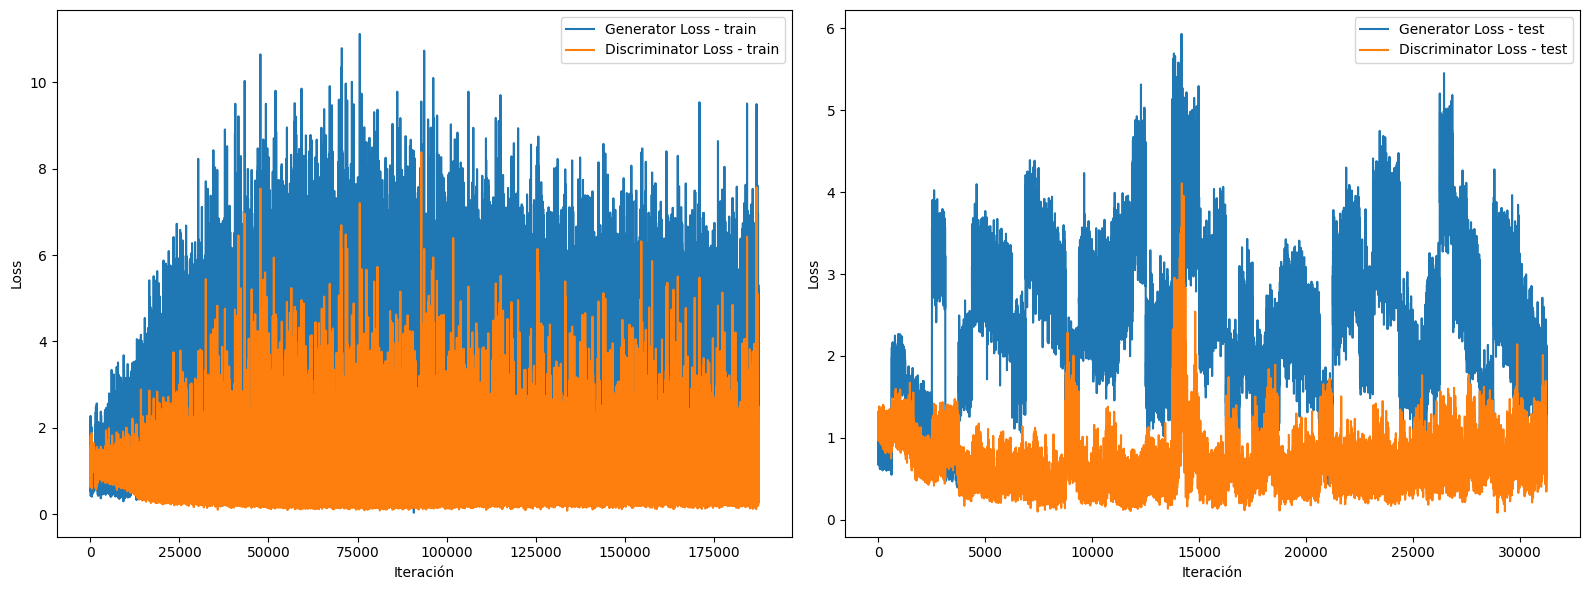

In [22]:
data = np.load("metricas_mnist_m1.npz")

iteration_train = np.arange(1, len(X_train)/batch_size*epoch_count+1)
iteration_test = np.arange(1, len(X_test)/batch_size*epoch_count+1)
d_loss_itern_train = data['d_loss_itern_train']
g_loss_itern_train = data['g_loss_itern_train']
d_loss_itern_test = data['d_loss_itern_test']
g_loss_itern_test = data['g_loss_itern_test']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(iteration_train, g_loss_itern_train, label='Generator Loss - train')
axs[0].plot(iteration_train, d_loss_itern_train, label='Discriminator Loss - train')
axs[0].set_xlabel('Iteración')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(iteration_test, g_loss_itern_test, label='Generator Loss - test')
axs[1].plot(iteration_test, d_loss_itern_test, label='Discriminator Loss - test')
axs[1].set_xlabel('Iteración')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

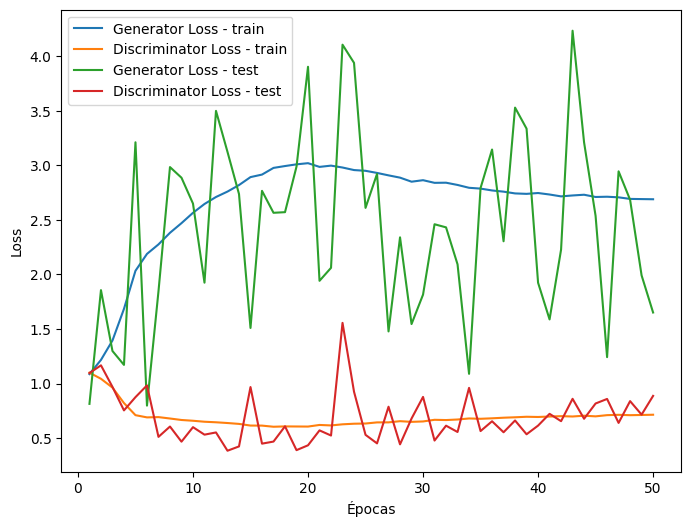

In [23]:
data = np.load("metricas_mnist_m1.npz")
epochs = data['epochs']
d_loss_train = data['d_loss_train']
g_loss_train = data['g_loss_train']
d_loss_test = data['d_loss_test']
g_loss_test = data['g_loss_test']

plt.figure(figsize=(8,6))
epochs = np.arange(1, epoch_count+1)
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficas de las métricas para el discriminador en función del número de épocas

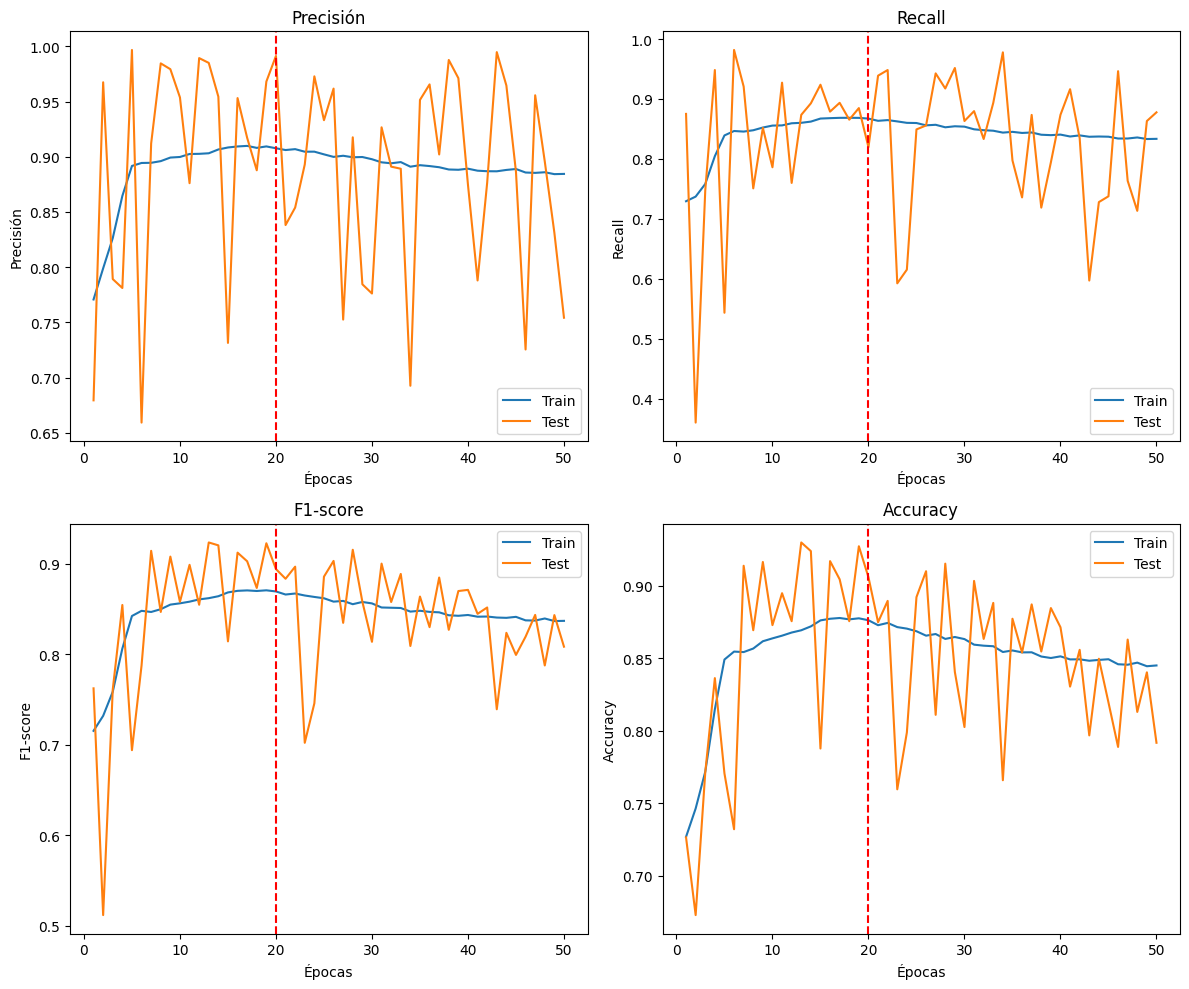

In [24]:
data = np.load("metricas_mnist_m1.npz")
epochs = data['epochs']
precision_train = data['precision_train']
recall_train = data['recall_train']
f1_train = data['f1_train']
accuracy_train = data['accuracy_train']
precision_test = data['precision_test']
recall_test = data['recall_test']
f1_test = data['f1_test']
accuracy_test = data['accuracy_test']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].axvline(x=20, color='r', linestyle='--')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].axvline(x=20, color='r', linestyle='--')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].axvline(x=20, color='r', linestyle='--')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].axvline(x=20, color='r', linestyle='--')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')

plt.tight_layout()
plt.show()